# STEM Optimization Analysis

This notebook demonstrates the basic functionality of the intensity analysis by using the optimization method 

Third-Party Python packages required:

Package "tifffile" for opening the experimental target image

Package "ASE" for importing the initial model


In [8]:
%matplotlib notebook
import os,sys
sys.path.append('/home/christoph/repos/stem_optimization/')
from Model import Model
from Simulation import Simulation
from ase.io import read, write
import matplotlib.pyplot as plt
from tifffile import tifffile
import numpy as np
#import time
import threading
import pickle
from ase.visualize import view
from ase import Atoms

We start by loading the target image, which has to be an atomically resolved STEM-ADF image and initializing important parameters for the simulation.

We also start a new thread to plot and update the target image, the simulation, the difference, the PSF and the correlation.


<IPython.core.display.Javascript object>


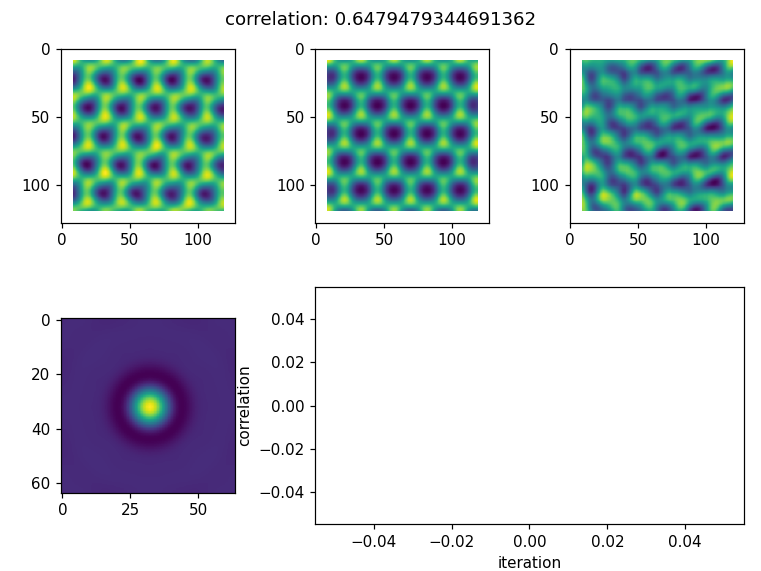

In [9]:
path = '/data_disk2_18tb/WS2_charge/stemopt/defects/PtychoOpt/STEMprobe/exp/'
os.chdir(path)
image = tifffile.imread('20_mrad_exp.tif').T
model = read('ws2.xyz')
image[:8] = np.nan
image[-8:] = np.nan
image[:,:8] = np.nan
image[:,-8:] = np.nan

reset = True # False if specific pickle file is used
#model.positions[:,2] = 0
#model = Atoms('W2S',positions=[[2,2,0],[2,8,0],[2,3.7,0]])
#model[55].position+=[0,-0.2,0]
#model[57].position+=[0,-0.1,0]
#model.rotate('x',3)
## The size of the kernel which is used for image convolution is chosen to be 
# "1/kernelsize" of the image size (in pixels)
model.rotate('x',8)

if reset:
    m = Model(model,image, kernelsize=2, start_PlotThread=True,contrast = 0.5)

    conv_angle = 0.02 #rad
    energy = 60000 #eV
    fov = 1.69#nm

    pixel0  =  [6,8]
        
    atom0 =  0
    px = np.max(image.shape)
    #blur = 1
    blur = px/(fov*10)*0.0## 0.3 A source size
    m.set_up_simulation(conv_angle, energy, fov , blur=blur,atom0 = atom0, pixel0=pixel0,method='SSB' )

    plot_thread = threading.Thread(target = m.plotting_thread,args = (m.fig,m.ax), daemon=True)
    plot_thread.start()
    
else:
    ## this code can load the pickle object again

    with open(path+'model_init.pkl', 'rb') as pickle_file:
        m = pickle.load(pickle_file)



We now run the optimization, while the plot above constantely updates

Possible parameters: aberrations, blur, positions, fov, intensities

In [3]:
#starttime = time.time()

rounds=30
#m.optimize_model(['tilt'],iterations = rounds)
m.optimize_model(['fov','blur','translation','scale'],iterations = rounds)
m.optimize_model(['fov','blur','intensities'],iterations = rounds)
#rounds=30

#m.optimize_model(['fov','blur','tilt','intensities' ,'positions'],iterations = rounds)

#m.optimize_model(['fov','blur','tilt','positions','intensities'],iterations = rounds)
#rounds = 10
#m.optimize_model(['aberrations','blur','intensities'],iterations = rounds)
#m.optimize_model(['intensities','positions'],iterations = rounds)
#rounds = 40

#print('method finished after '+str((time.time()-starttime)/rounds)+' seconds per iteration' )
write('model_optimized.xyz',m.ase)
np.save('model.parameters',m.get_parameters(),allow_pickle=True)


100%|██████████| 30/30 [01:20<00:00,  2.69s/it]


To save the object, pickle is used 

We can now analyze the atomic intensities.

<IPython.core.display.Javascript object>


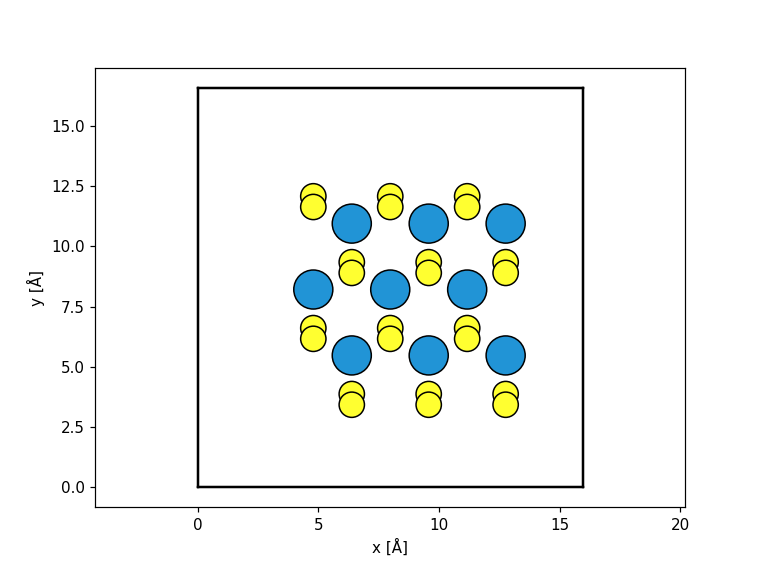

<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>

In [4]:
from abtem.visualize import show_atoms
at = m.ase
sel = (at.get_positions()[:,1]>3)*(at.get_positions()[:,1]<13)*(at.get_positions()[:,0]>3.5)*(at.get_positions()[:,0]<13)
ws = at[(at.numbers==74)*sel]
s = at[(at.numbers==16)*sel]
show_atoms(at[sel])


In [5]:
pxpos = m.sim.unit_conversion()
total_scattering=m.total_scattering/np.mean(m.total_scattering)

ints_w = total_scattering[(at.numbers==74)*sel]
ints_s = total_scattering[(at.numbers==16)*sel]


<IPython.core.display.Javascript object>


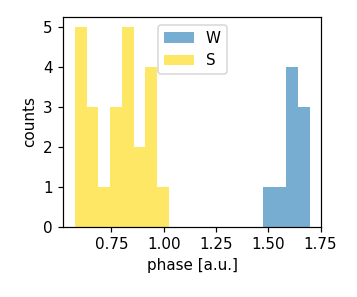

In [6]:
plt.figure(figsize=(3,2.5))
n,bins = np.histogram(np.hstack([ints_w,ints_s]),bins =20)
plt.hist(ints_w,bins,alpha=0.6,label='W')
plt.hist(ints_s,bins,alpha=0.6,label='S',color='gold')
plt.legend()
plt.xlabel('phase [a.u.]')
plt.ylabel('counts')
plt.tight_layout()
plt.savefig('histogram.svg')
plt.show()

In [7]:
np.mean(ints_s)*2/np.mean(ints_w)

0.9633590558199162